In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import deepcopy
from tqdm import tqdm
from balu3.fs.sel    import sfs, clean
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from random import randint
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical
from scipy.stats import binom, betabinom
from tensorflow.keras.preprocessing.sequence import pad_sequences
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
import keras

In [2]:
#Para la LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Data historica

dfHistorico1 = pd.read_csv("dataHistórica/resultados_pasados_premier.csv")
dfHistorico1 = dfHistorico1.drop("Unnamed: 0",axis = 1)
dfHistorico1 = dfHistorico1.drop(["Position_last_year_home", "Position_last_year_away",
                                  "Points_last_year_home", "Points_last_year_away"],axis = 1) # Para hacer el merge con el segundo.

dfHistorico2 = pd.read_csv("dataHistórica/restoDeLigas.csv")
dfHistorico2 = dfHistorico2.drop("Unnamed: 0",axis = 1)

dfHistorico2['Date'] = pd.to_datetime(dfHistorico2['Date'], dayfirst=True, errors='coerce')
dfHistorico2['Date'] = dfHistorico2['Date'].dt.strftime('%Y-%m-%d')
dfHistorico2 = dfHistorico2[dfHistorico2["Date"] >"2010-01-01"] # Seleccion solo de partidos de 2010 en adelante (porque el otro dataframe tiene info desde ahí)


C:\Users\gfuen\AppData\Local\Temp\ipykernel_4608\788853108.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfHistorico2['Date'] = pd.to_datetime(dfHistorico2['Date'], dayfirst=True, errors='coerce')


In [4]:
dfHistorico = pd.concat([dfHistorico1, dfHistorico2], axis=0)
dfHistorico = dfHistorico.reset_index(drop=True)

In [5]:
# Data tipo evento

dfEvent = pd.read_csv("dataWhoScored/WhoScoredTeamPerMatchSpatial4x3TimeDiv5.csv")
dfEvent = dfEvent.drop("Unnamed: 0",axis = 1)

In [6]:
# Ajuste manual de equipos:
# Los que no tengan match son un string vacio.

histToEventNameV1 = {
   "Arsenal": "Arsenal", "Aston Villa": "Aston Villa", "Barnsley": "", "Birmingham City": "Birmingham", "Blackburn": "Blackburn","Blackpool": "Blackpool",
   "Bolton" : "Bolton", "Bournemouth": "Bournemouth", "Bradford City": "", "Brentford": "Brentford", "Brighton": "Brighton", "Burnley": "Burnley", "Cardiff City": "Cardiff",
   "Charlton Ath": "", "Chelsea": "Chelsea", "Coventry City": "", "Crystal Palace": "Crystal Palace", "Derby County":"", "Everton": "Everton", "Fulham": "Fulham",
   "Huddersfield": "Huddersfield", "Hull City": "Hull", "Ipswich Town": "", "Leeds United": "Leeds", "Leicester City": "Leicester", "Liverpool": "Liverpool",
   "Manchester City": "Man City", "Manchester Utd": "Man Utd", "Middlesbrough": "Middlesbrough", "Newcastle Utd": "Newcastle", "Norwich City": "Norwich",
   "Nott'ham Forest": "Nottingham Forest", "Oldham Athletic": "", "Portsmouth": "", "QPR": "QPR", "Reading": "Reading", "Sheffield Utd": "Sheff Utd", "Sheffield Weds": "",
   "Southampton": "Southampton", "Stoke City": "Stoke", "Sunderland": "Sunderland", "Swansea City": "Swansea", "Swindon Town":  "", "Tottenham": "Tottenham", "Watford":"Watford",
   "West Brom": "WBA", "West Ham": "West Ham", "Wigan Athletic": "Wigan", "Wimbledon": "", "Wolves": "Wolves"
}
len(histToEventNameV1)

50

In [7]:
histToEventName = {
   "Arsenal": "Arsenal", "Aston Villa": "Aston Villa", "Barnsley": "", "Birmingham City": "Birmingham", "Blackburn": "Blackburn","Blackpool": "Blackpool",
   "Bolton" : "Bolton", "Bournemouth": "Bournemouth", "Bradford City": "", "Brentford": "Brentford", "Brighton": "Brighton", "Burnley": "Burnley", "Cardiff City": "Cardiff",
   "Charlton Ath": "", "Chelsea": "Chelsea", "Coventry City": "", "Crystal Palace": "Crystal Palace", "Derby County":"", "Everton": "Everton", "Fulham": "Fulham",
   "Huddersfield": "Huddersfield", "Hull City": "Hull", "Ipswich Town": "", "Leeds United": "Leeds", "Leicester City": "Leicester", "Liverpool": "Liverpool",
   "Manchester City": "Man City", "Manchester Utd": "Man Utd", "Middlesbrough": "Middlesbrough", "Newcastle Utd": "Newcastle", "Norwich City": "Norwich",
   "Nott'ham Forest": "Nottingham Forest", "Oldham Athletic": "", "Portsmouth": "", "QPR": "QPR", "Reading": "Reading", "Sheffield Utd": "Sheff Utd", "Sheffield Weds": "",
   "Southampton": "Southampton", "Stoke City": "Stoke", "Sunderland": "Sunderland", "Swansea City": "Swansea", "Swindon Town":  "", "Tottenham": "Tottenham", "Watford":"Watford",
   "West Brom": "WBA", "West Ham": "West Ham", "Wigan Athletic": "Wigan", "Wimbledon": "", "Wolves": "Wolves", #V1
   "Aachen":"","Ajaccio":"AC Ajaccio", "Alaves":"Deportivo Alaves", "Almeria": "Almeria", "Amiens":"Amiens","Angers":"Angers", "Arles":"Arles-Avignon", "Ascoli":"",
   "Atalanta":"Atalanta", "Ath Bilbao":"Athletic Club", "Ath Madrid":"Atletico", "Augsburg":"Augsburg", "Auxerre":"Auxerre", "Barcelona":"Barcelona", "Bari":"Bari",
   "Bastia":"SC Bastia", "Bayern Munich":"Bayern", "Benevento":"Benevento", "Betis":"Real Betis", "Bielefeld":"Arminia Bielefeld", "Bochum": "Bochum", "Bologna":"Bologna",
   "Bordeaux":"Bordeaux", "Boulogne": "", "Braunschweig": "Eintracht Braunschweig", "Brescia":"Brescia", "Brest":"Brest", "Cadiz":"Cadiz", "Caen": "Caen", "Cagliari":"Cagliari",
   "Carpi":"AC Carpi", "Catania":"Catania", "Celta":"Celta Vigo", "Cesena": "Cesena", "Chievo":"Chievo", "Clermont":"Clermont Foot", "Cordoba": "Cordoba", "Cottbus":"",
   "Cremonese":"Cremonese", "Crotone":"Crotone", "Darmstadt":"Darmstadt", "Dijon": "Dijon", "Dortmund":"Borussia Dortmund", "Duisburg":"", "Eibar":"Eibar", "Ein Frankfurt":"Eintracht Frankfurt",
   "Elche": "Elche", "Empoli": "Empoli", "Espanol": "Espanyol", "Evian Thonon Gaillard": "Evian", "FC Koln": "FC Koln", "Fiorentina": "Fiorentina", "Fortuna Dusseldorf": "Fortuna Duesseldorf",
   "Freiburg":"Freiburg", "Frosinone": "Frosinone", "Genoa": "Genoa", "Getafe": "Getafe", "Gimnastic":"", "Girona": "Girona", "Granada": "Granada", "Grenoble":"",
   "Greuther Furth": "Greuther Fuerth", "Guingamp": "Guingamp", "Hamburg":"Hamburg", "Hannover":"Hannover", "Hansa Rostock":"", "Heidenheim":"FC Heidenheim", "Hercules":"Hercules",
   "Hertha":"Hertha Berlin", "Hoffenheim":"Hoffenheim", "Huesca": "SD Huesca", "Ingolstadt": "Ingolstadt", "Inter": "Inter", "Juventus":"Juventus", "Kaiserslautern":"Kaiserslautern",
   "Karlsruhe":"", "La Coruna": "Deportivo", "Las Palmas": "Las Palmas", "Lazio": "Lazio", "Le Havre": "Le Havre", "Le Mans":"", "Lecce": "Lecce", "Leganes":"Leganes", "Lens": "Lens",
   "Levante": "Levante", "Leverkusen": "Leverkusen", "Lille":"Lille", "Livorno": "Livorno", "Lorient":"Lorient", "Lyon": "Lyon", "M'gladbach": "Borussia M.Gladbach", "Mainz": "Mainz",
   "Malaga":"Malaga", "Mallorca":"Mallorca", "Messina": "", "Metz": "Metz", "Milan": "AC Milan", "Monaco": "Monaco", "Montpellier": "Montpellier", "Monza": "Monza", "Murcia":"",
   "Nancy":"Nancy", "Nantes":"Nantes", "Napoli":"Napoli", "Nice":"Nice", "Nimes":"Nimes", "Novara": "Novara", "Numancia":"", "Nurnberg":"Nuernberg", "Osasuna": "Osasuna",
   "Paderborn": "Paderborn", "Palermo": "Palermo", "Paris SG": "PSG", "Parma": "Parma Calcio 1913", "Pescara":"Pescara", "RB Leipzig": "RBL","Real Madrid":"Real Madrid", 
   "Recreativo":"", "Reggina":"", "Reims": "Reims", "Rennes":"Rennes", "Roma":"Roma", "Salernitana": "Salernitana", "Sampdoria":"Sampdoria", "Santander": "Racing Santander",
   "Sassuolo":"Sassuolo", "Schalke 04": "Schalke", "Sedan":"", "Sevilla":"Sevilla", "Siena": "Siena", "Sochaux": "Sochaux", "Sociedad": "Real Sociedad", "Sp Gijon":"Sporting Gijon",
   "Spal":"SPAL 2013", "Spezia": "Spezia", "St Etienne":"Saint-Etienne", "St Pauli":"St. Pauli", "Strasbourg":"Strasbourg", "Stuttgart": "Stuttgart", "Tenerife":"", "Torino":"Torino",
   "Toulouse":"Toulouse", "Treviso":"", "Troyes":"Troyes", "Udinese": "Udinese", "Union Berlin":"Union Berlin", "Valencia": "Valencia", "Valenciennes": "Valenciennes", "Valladolid": "Real Valladolid",
   "Vallecano": "Rayo Vallecano", "Venezia":"Venezia", "Verona":"Verona", "Villarreal": "Villarreal", "Werder Bremen": "Werder Bremen", "Wolfsburg": "Wolfsburg", "Xerez": "", "Zaragoza": "Real Zaragoza"
}
len(histToEventName)

207

In [8]:
# Para buscar nombres

a = dfHistorico["Team_home"].unique().tolist()
a.sort()
print(a)

['Ajaccio', 'Ajaccio GFCO', 'Alaves', 'Almeria', 'Amiens', 'Angers', 'Arles', 'Arsenal', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre', 'Barcelona', 'Bari', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Birmingham City', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Boulogne', 'Bournemouth', 'Bradford City', 'Braunschweig', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari', 'Cardiff City', 'Carpi', 'Catania', 'Celta', 'Cesena', 'Charlton Ath', 'Chelsea', 'Chievo', 'Clermont', 'Cordoba', 'Coventry City', 'Cremonese', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Derby County', 'Dijon', 'Dortmund', 'Eibar', 'Ein Frankfurt', 'Elche', 'Empoli', 'Espanol', 'Everton', 'Evian Thonon Gaillard', 'FC Koln', 'Fiorentina', 'Fortuna Dusseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'Genoa', 'Getafe', 'Girona', 'Granada', 'Grenoble', 'Greuther Furth', 'Guingamp', 'Hamburg', 'Hannover', 'H

In [9]:
# Para buscar nombres

a = dfEvent["Team"].unique().tolist()
a.sort()
print(a)

['AC Ajaccio', 'AC Carpi', 'AC Milan', 'Almeria', 'Amiens', 'Angers', 'Arles-Avignon', 'Arminia Bielefeld', 'Arsenal', 'Aston Villa', 'Atalanta', 'Athletic Club', 'Atletico', 'Augsburg', 'Auxerre', 'Barcelona', 'Bari', 'Bayern', 'Benevento', 'Birmingham', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Borussia Dortmund', 'Borussia M.Gladbach', 'Bournemouth', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Burnley', 'Cadiz', 'Caen', 'Cagliari', 'Cardiff', 'Catania', 'Celta Vigo', 'Cesena', 'Chelsea', 'Chievo', 'Clermont Foot', 'Cordoba', 'Cremonese', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Deportivo', 'Deportivo Alaves', 'Dijon', 'Eibar', 'Eintracht Braunschweig', 'Eintracht Frankfurt', 'Elche', 'Empoli', 'Espanyol', 'Everton', 'Evian', 'FC Heidenheim', 'FC Koln', 'Fiorentina', 'Fortuna Duesseldorf', 'Freiburg', 'Frosinone', 'Fulham', 'GFC Ajaccio', 'Genoa', 'Getafe', 'Girona', 'Granada', 'Greuther Fuerth', 'Guingamp', 'Hamburg', 'Hannover', 'Hercules', 'Hertha B

In [10]:
# Nombres de data histórica a nombres de tipo evento.

dfHistorico["Team_home"] = dfHistorico["Team_home"].map(histToEventName)
dfHistorico["Team_away"] = dfHistorico["Team_away"].map(histToEventName)

In [11]:
# Comprobamos que no esten datos vacios

dfHistorico.isnull().sum() 

Wk                                 0
Date                               0
Team_home                        284
Team_away                        281
Goals_home                         0
Goals_away                         0
score_prom_home                    0
score_prom_away                    0
wins_home                          0
wins_away                          0
ties_home                          0
ties_away                          0
losses_home                        0
losses_away                        0
total_goals_home                   0
total_goals_away                   0
total_goals_conceded_home          0
total_goals_conceded_away          0
points_home                        0
points_away                        0
streak_home                        0
streak_away                        0
wins_in_last_5_matches_home        0
wins_in_last_5_matches_away        0
ties_in_last_5_matches_home        0
ties_in_last_5_matches_away        0
losses_in_last_5_matches_home      0
l

In [12]:
# Primero revisamos si estan todos los partidos compatibles, para que sea más robusta la solución

indexHistorical = []
for i in tqdm(range(len(dfHistorico))):
    stringHome = dfHistorico.iloc[i].Team_home
    stringAway = dfHistorico.iloc[i].Team_away
    date = dfHistorico.iloc[i].Date

    dfAux = dfEvent[dfEvent.Date == date]

    dfHome = dfAux[dfAux.Team == stringHome].add_prefix("Home")
    dfAway = dfAux[dfAux.Team == stringAway].add_prefix("Away")

    # dfHome.reset_index(drop=True, inplace=True)
    # dfAway.reset_index(drop=True, inplace=True)
    if len(dfHome) + len(dfAway) == 2: 
        indexHistorical.append(i)
    # concat = pd.concat([dfHome, dfAway], axis = 1)
    # test.append(concat)
    # Buscamos los partidos que tenemos información
    

100%|██████████| 31979/31979 [04:21<00:00, 122.26it/s]


In [13]:
# Creamos el dataframe de partidos a buscar

dfHistoricoCompatible = dfHistorico.iloc[indexHistorical].reset_index(drop=True)
dfHistoricoCompatible = dfHistoricoCompatible.dropna(axis=0)

In [14]:
dfHistoricoCompatible

,Wk,Date,Team_home,Team_away,Goals_home,Goals_away,score_prom_home,score_prom_away,wins_home,wins_away,...,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away,result
0,1.0,2010-08-14,Bolton,Fulham,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,2010-08-14,Wigan,Blackpool,0.0,4.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1.0,2010-08-14,Tottenham,Man City,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,2010-08-14,Aston Villa,West Ham,3.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1.0,2010-08-14,Chelsea,WBA,6.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22204,23.0,2024-02-23,Leverkusen,Mainz,2.0,1.0,2.590909,0.772727,18.0,2.0,...,15.0,22.0,1.0,4.0,1.0,1.0,1.0,0.0,3.0,1
22205,23.0,2024-02-24,Borussia M.Gladbach,Bochum,5.0,2.0,1.636364,1.181818,5.0,5.0,...,25.0,0.0,3.0,0.0,1.0,2.0,3.0,3.0,1.0,1
22206,23.0,2024-02-24,Stuttgart,FC Koln,1.0,1.0,2.318182,0.681818,15.0,3.0,...,16.0,4.0,0.0,4.0,1.0,0.0,2.0,1.0,2.0,0
22207,23.0,2024-02-24,Union Berlin,FC Heidenheim,2.0,2.0,0.954545,1.409091,7.0,7.0,...,27.0,2.0,0.0,3.0,1.0,1.0,3.0,1.0,1.0,0


In [15]:
dfHistoricoCompatible.isnull().sum()

Wk                               0
Date                             0
Team_home                        0
Team_away                        0
Goals_home                       0
Goals_away                       0
score_prom_home                  0
score_prom_away                  0
wins_home                        0
wins_away                        0
ties_home                        0
ties_away                        0
losses_home                      0
losses_away                      0
total_goals_home                 0
total_goals_away                 0
total_goals_conceded_home        0
total_goals_conceded_away        0
points_home                      0
points_away                      0
streak_home                      0
streak_away                      0
wins_in_last_5_matches_home      0
wins_in_last_5_matches_away      0
ties_in_last_5_matches_home      0
ties_in_last_5_matches_away      0
losses_in_last_5_matches_home    0
losses_in_last_5_matches_away    0
result              

In [16]:
# goals_succ = dfEvent.filter(regex='Goal_Successful_bin').columns.tolist()
# goals_unsucc = dfEvent.filter(regex='Goal_Unsuccessful_bin').columns.tolist()
# goals_succ.extend(goals_unsucc)
# goals = goals_succ

# intervals = ["0-45","45-90"]
# intervals = ["0-15","15-30","30-45","45-60","60-75","75-90"]
intervals = ["0-5","5-10","10-15","15-20","20-25","25-30", "30-35","35-40","40-45",
             "45-50","50-55","55-60","60-65","65-70","70-75", "75-80","80-85","85-90"]

Xdata = []
ydata = []
for i in tqdm(range(len(dfHistoricoCompatible))):
    stringHome = dfHistoricoCompatible.iloc[i].Team_home
    stringAway = dfHistoricoCompatible.iloc[i].Team_away
    date = dfHistoricoCompatible.iloc[i].Date

    # dfAux = dfEvent[dfEvent.Date == date].drop(goals, axis=1) #Test sin los goles
    dfAux = dfEvent[dfEvent.Date == date]

    dfHome = dfAux[dfAux.Team == stringHome].add_prefix("Home")
    dfAway = dfAux[dfAux.Team == stringAway].add_prefix("Away")

    # Dropear valores redundantes
    dfHome = dfHome.drop(["HomeTeam","HomeDate","HomeGoals","Homegame_id"], axis = 1)
    dfAway = dfAway.drop(["AwayTeam","AwayDate","AwayGoals","Awaygame_id"], axis = 1)

    dfHome.reset_index(drop=True, inplace=True)
    dfAway.reset_index(drop=True, inplace=True)

    concat = pd.concat([dfHome, dfAway], axis = 1).reset_index(drop=True)
    x = []
    if len(concat) == 0:
        pass
    else:
        for inter in intervals:
            intervals_columns = concat.filter(regex=f'{inter}$').columns.tolist()
            hist = dfHistoricoCompatible.iloc[i:i+1].drop(["Date", "Team_home", "Team_away", "result", "Goals_home", "Goals_away", "Wk"], axis=1).values
            x.append(np.append(concat[intervals_columns].values[0], hist))
        ydata.append(dfHistoricoCompatible.iloc[i:i+1]["result"].values[0])
        x = np.array(x)
        Xdata.append(x)

100%|██████████| 22209/22209 [1:02:00<00:00,  5.97it/s]


In [18]:
# Para guardar el dataset y no correrlo varias veces 
np.save("Space4x3Time5.np", np.array(Xdata))

In [19]:
# Full data
X = np.array(Xdata)
y = np.array(ydata)
y = to_categorical(y, num_classes=3)

# Mitad de los datos
# X = np.array(Xdata)[:, :10, :]


In [20]:
X.shape

(22209, 18, 1270)

In [21]:
y.shape

(22209, 3)

In [22]:
# Dividir los datos en conjuntos de entrenamiento y prueba
split = int(0.8 * X.shape[0])
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [23]:
# Sin clean
# scaler = MinMaxScaler()
# X_train_reshaped = X_train.reshape(-1, X.shape[2])
# X_train_normalized = scaler.fit_transform(X_train_reshaped)
# X_train_normalized = X_train_normalized.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

# X_test_reshaped = X_test.reshape(-1, X.shape[2])
# X_test_normalized = scaler.transform(X_test_reshaped)
# X_test_normalized = X_test_normalized.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


# Con clean 
X_train_reshaped = X_train.reshape(-1, X.shape[2])
X_test_reshaped = X_test.reshape(-1, X.shape[2])

sclean  = clean(X_train_reshaped)      # indices of selected features
X_train_reshaped = deepcopy(X_train_reshaped[:,sclean])
X_test_reshaped = deepcopy(X_test_reshaped[:,sclean])

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_reshaped)
X_test_normalized = scaler.transform(X_test_reshaped)

X_train_normalized = X_train_normalized.reshape(X_train.shape[0], X_train.shape[1], len(sclean))
X_test_normalized = X_test_normalized.reshape(X_test.shape[0], X_test.shape[1], len(sclean))


In [25]:
X_train_normalized.shape

(17767, 18, 766)

In [26]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


In [28]:
from tensorflow.keras.layers import Masking, LSTM, Dense

In [31]:
# Definir el modelo LSTM
model = Sequential()
l2_recurrent_parameter = 1
l_2_kernel_regularizer= 1
# Primera capa LSTM con Dropout y regularización L2
model.add(LSTM(256, return_sequences=True, input_shape=(X_train_normalized.shape[1], X_train_normalized.shape[2]),
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=False,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
# Compilación del modelo
with tf.device('GPU:0'): # Usar gpu
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath="models\Full",
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0000000001)

history = model.fit(X_train_normalized, y_train, verbose=1, epochs=1000, batch_size=16,
                    validation_data=(X_test_normalized, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/1000
1111/1111 [==============================] - 23s 17ms/step - loss: 44.8883 - accuracy: 0.4555 - val_loss: 2.6146 - val_accuracy: 0.3028 - lr: 0.0010
Epoch 2/1000
1111/1111 [==============================] - 17s 16ms/step - loss: 1.0811 - accuracy: 0.6159 - val_loss: 1.2657 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 3/1000
1111/1111 [==============================] - 18s 16ms/step - loss: 1.0337 - accuracy: 0.6867 - val_loss: 1.5194 - val_accuracy: 0.3656 - lr: 0.0010
Epoch 4/1000
1111/1111 [==============================] - 18s 16ms/step - loss: 0.8251 - accuracy: 0.7301 - val_loss: 1.2749 - val_accuracy: 0.6655 - lr: 0.0010
Epoch 5/1000
1111/1111 [==============================] - 18s 16ms/step - loss: 0.7791 - accuracy: 0.7358 - val_loss: 0.6990 - val_accuracy: 0.7701 - lr: 0.0010
Epoch 6/1000
1111/1111 [==============================] - 18s 16ms/step - loss: 0.7653 - accuracy: 0.7433 - val_loss: 2.9550 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 7/1000
1111/1111 [=========

In [32]:
loss, acc = [], []
for i in range(1, X_test_normalized.shape[1]+1):
    print(intervals[i-1])
    aux = model.evaluate(X_test_normalized[:, :i, :], y_test)
    loss.append(aux[0])
    acc.append(aux[1])

0-5
139/139 [==============================] - 2s 7ms/step - loss: 5.2524 - accuracy: 0.4604
5-10
139/139 [==============================] - 1s 6ms/step - loss: 7.8394 - accuracy: 0.4845
10-15
139/139 [==============================] - 1s 6ms/step - loss: 8.3760 - accuracy: 0.5036
15-20
139/139 [==============================] - 1s 7ms/step - loss: 7.7167 - accuracy: 0.5209
20-25
139/139 [==============================] - 1s 7ms/step - loss: 6.7070 - accuracy: 0.5358
25-30
139/139 [==============================] - 1s 7ms/step - loss: 5.8453 - accuracy: 0.5511
30-35
139/139 [==============================] - 1s 7ms/step - loss: 4.9963 - accuracy: 0.5646
35-40
139/139 [==============================] - 1s 7ms/step - loss: 4.1898 - accuracy: 0.5835
40-45
139/139 [==============================] - 1s 7ms/step - loss: 3.5135 - accuracy: 0.5997
45-50
139/139 [==============================] - 1s 7ms/step - loss: 2.8880 - accuracy: 0.6195
50-55
139/139 [==============================] - 1s 7

## Pruebas con padding

Media de las muestras: 12.585438335809807


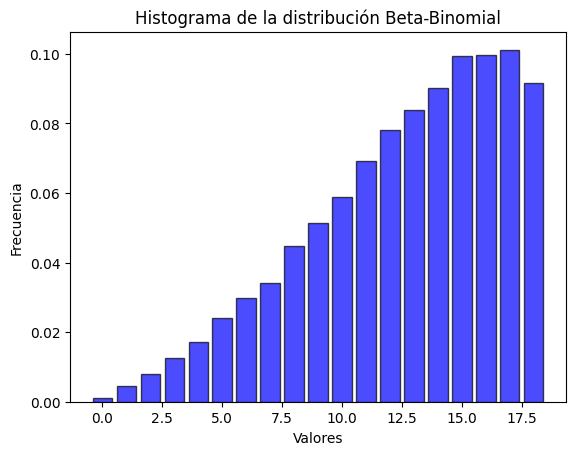

In [82]:
import numpy as np
from scipy.stats import betabinom

# Parámetros de la distribución beta-binomial
n = X.shape[1]   # Número de ensayos
a = 0.70*4  # Parámetro alpha de la distribución beta
b = 0.30*4   # Parámetro beta de la distribución beta

# Número de muestras aleatorias que deseas generar
num_samples = X.shape[0]

# Generar números aleatorios de una distribución beta-binomial
samples = betabinom.rvs(n, a, b, size=num_samples)

# Calcular y mostrar la media de las muestras generadas
mean_samples = np.mean(samples)
print(f"Media de las muestras: {mean_samples}")

values, counts = np.unique(samples, return_counts=True)

# Graficar un barplot de las muestras generadas
plt.bar(values, counts / num_samples, color='b', edgecolor='black', alpha=0.7)

# Títulos y etiquetas
plt.title('Histograma de la distribución Beta-Binomial')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')

# Mostrar la gráfica
plt.show()

In [83]:
# Full data
XFullpad = np.array(Xdata)
y = np.array(ydata)
y = to_categorical(y, num_classes=3)


In [84]:
# Dividir los datos en conjuntos de entrenamiento y prueba

split = int(0.8 * XFullpad.shape[0])
XFullpad_train, XFullpad_test = XFullpad[:split], XFullpad[split:]

# # Sin clean
# scaler = MinMaxScaler()
# XFullpad_train_reshaped = XFullpad_train.reshape(-1, X.shape[2])
# XFullpad_train_normalized = scaler.fit_transform(XFullpad_train_reshaped)
# XFullpad_train_normalized = XFullpad_train_normalized.reshape(XFullpad_train.shape[0], XFullpad_train.shape[1], XFullpad_train.shape[2])

# XFullpad_test_reshaped = XFullpad_test.reshape(-1, X.shape[2])
# XFullpad_test_normalized = scaler.transform(XFullpad_test_reshaped)
# XFullpad_test_normalized = XFullpad_test_normalized.reshape(XFullpad_test.shape[0], XFullpad_test.shape[1], XFullpad_test.shape[2])

# Con clean 
XFullpad_train_reshaped = XFullpad_train.reshape(-1, X.shape[2])
XFullpad_test_reshaped = XFullpad_test.reshape(-1, X.shape[2])

sclean  = clean(XFullpad_train_reshaped)      # indices of selected features
XFullpad_train_reshaped = deepcopy(XFullpad_train_reshaped[:,sclean])
XFullpad_test_reshaped = deepcopy(XFullpad_test_reshaped[:,sclean])

scaler = MinMaxScaler()
XFullpad_train_normalized = scaler.fit_transform(XFullpad_train_reshaped)
XFullpad_test_normalized = scaler.transform(XFullpad_test_reshaped)

XFullpad_train_normalized = XFullpad_train_normalized.reshape(XFullpad_train.shape[0], XFullpad_train.shape[1], len(sclean))
XFullpad_test_normalized = XFullpad_test_normalized.reshape(XFullpad_test.shape[0], XFullpad_test.shape[1], len(sclean))



In [85]:
XFullpad_train_normalized.shape

(17767, 18, 766)

In [86]:
# Parámetros de la distribución binomial 
# n = X.shape[1]
# p = 0.9
# size = X.shape[0]
# random_values = binom.rvs(n, p, size=size)

# Parámetros de la distribución beta-binomial
n = XFullpad.shape[1]   # Número de ensayos
size = XFullpad.shape[0]
a = 0.70*4  # Parámetro alpha de la distribución beta
b = 0.30*4   # Parámetro beta de la distribución beta

random_values = betabinom.rvs(n, a, b, size=size)

# random_values = np.random.randint(1, n+1, size)

In [87]:
#Binom  and uniform
Xpad_train = []
ypad_train = []
for i in range(split):
    Xpad_train.append(XFullpad_train_normalized[i][:random_values[i]+1])
    ypad_train.append(y[i])

Xpad_test = []
ypad_test = []
for i in range(len(XFullpad)-split):
    Xpad_test.append(XFullpad_test_normalized[i][:random_values[i+split]+1])
    ypad_test.append(y[i+split])

# Full
# Xpad = []
# ypad = []
# for i in range(size):
#     for j in range(n):
#         Xpad.append(X[i][:j+1])
#         ypad.append(y[i])

In [88]:
Xpad_train = pad_sequences(Xpad_train, padding='post', dtype='float64')
Xpad_test = pad_sequences(Xpad_test, padding='post', dtype='float64')
ypad_train = np.array(ypad_train)
ypad_test = np.array(ypad_test)

In [89]:
ypad_train.shape

(17767, 3)

In [90]:
Xpad_train.shape

(17767, 18, 766)

In [91]:
from tensorflow.keras.layers import LSTM, Dense, Embedding


l2_recurrent_parameter = 0.01
l_2_kernel_regularizer= 0.01

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(Xpad_train.shape[1], Xpad_train.shape[2])))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=False,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
# Compilación del modelo
with tf.device('GPU:0'): # Usar gpu
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath="models\Full",
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=10^(-9))

history = model.fit(Xpad_train, ypad_train, verbose=1, epochs=1000, batch_size=16,
                    validation_data=(Xpad_test, ypad_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/1000
1111/1111 [==============================] - 46s 32ms/step - loss: 3.2970 - accuracy: 0.5336 - val_loss: 1.6510 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 2/1000
1111/1111 [==============================] - 32s 29ms/step - loss: 1.2033 - accuracy: 0.5698 - val_loss: 1.0740 - val_accuracy: 0.6594 - lr: 0.0010
Epoch 3/1000
1111/1111 [==============================] - 33s 29ms/step - loss: 0.9345 - accuracy: 0.6410 - val_loss: 0.8355 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 4/1000
1111/1111 [==============================] - 33s 29ms/step - loss: 0.8431 - accuracy: 0.6703 - val_loss: 0.9012 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 5/1000
1111/1111 [==============================] - 32s 29ms/step - loss: 0.7967 - accuracy: 0.6873 - val_loss: 0.7852 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 6/1000
1111/1111 [==============================] - 33s 29ms/step - loss: 0.7764 - accuracy: 0.6951 - val_loss: 0.7291 - val_accuracy: 0.7132 - lr: 0.0010
Epoch 7/1000
1111/1111 [==========

In [92]:
loss, acc = [], []
for i in range(1, XFullpad_test_normalized.shape[1]+1):
    print(intervals[i])
    aux = model.evaluate(XFullpad_test_normalized[:, :i, :], ypad_test)
    loss.append(aux[0])
    acc.append(aux[1])
print(np.mean(acc))

5-10
139/139 [==============================] - 5s 9ms/step - loss: 1.2446 - accuracy: 0.4500
10-15
139/139 [==============================] - 1s 8ms/step - loss: 1.0686 - accuracy: 0.4858
15-20
139/139 [==============================] - 1s 8ms/step - loss: 1.0168 - accuracy: 0.5115
20-25
139/139 [==============================] - 1s 8ms/step - loss: 0.9922 - accuracy: 0.5304
25-30
139/139 [==============================] - 1s 9ms/step - loss: 0.9668 - accuracy: 0.5520
30-35
139/139 [==============================] - 1s 9ms/step - loss: 0.9446 - accuracy: 0.5608
35-40
139/139 [==============================] - 1s 8ms/step - loss: 0.9197 - accuracy: 0.5734
40-45
139/139 [==============================] - 1s 9ms/step - loss: 0.8924 - accuracy: 0.5882
45-50
139/139 [==============================] - 1s 9ms/step - loss: 0.8634 - accuracy: 0.6074
50-55
139/139 [==============================] - 1s 9ms/step - loss: 0.8249 - accuracy: 0.6391
55-60
139/139 [==============================] - 1s

IndexError: list index out of range